In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.linalg as LA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
All_state_var_train_points = pd.read_csv("workspace_files\All_state_var_train_points.csv")
All_opt_var_train_points = pd.read_csv("workspace_files\All_opt_var_train_points.csv")

All_state_var_valid_points = pd.read_csv("workspace_files\All_state_var_valid_points.csv")
All_opt_var_valid_points = pd.read_csv("workspace_files\All_opt_var_valid_points.csv")

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:5: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:5: SyntaxWarning: invalid escape sequence '\A'
C:\Users\kuete\AppData\Local\Temp\ipykernel_22660\782511838.py:1: SyntaxWarning: invalid escape sequence '\A'
  All_state_var_train_points = pd.read_csv("workspace_files\All_state_var_train_points.csv")
C:\Users\kuete\AppData\Local\Temp\ipykernel_22660\782511838.py:2: SyntaxWarning: invalid escape sequence '\A'
  All_opt_var_train_points = pd.read_csv("workspace_files\All_opt_var_train_points.csv")
C:\Users\kuete\AppData\Local\Temp\ipykernel_22660\782511838.py:4: SyntaxWarning: invalid escape sequence '\A'
  All_state_var_valid_points = pd.read_csv("workspace_files\All_state_var_valid_points.c

In [4]:
All_state_var_train_points.columns = ['Vb', 'Vs', 'V', 'SOC']
All_opt_var_train_points.columns = ['J', 'V', 'SOC','I']

state_train = All_state_var_train_points[['Vb', 'Vs']]
opt_train = All_opt_var_train_points[['V', 'SOC','I']]

All_state_var_valid_points.columns = ['Vb', 'Vs', 'V', 'SOC']
All_opt_var_valid_points.columns = ['J', 'V', 'SOC','I']

state_test = All_state_var_valid_points[['Vb', 'Vs']]
opt_test = All_opt_var_valid_points[['V', 'SOC','I']]

In [5]:
state_test.values

array([[0.83728502, 0.83600167],
       [0.841023  , 0.86309135],
       [0.84636765, 0.86844617],
       ...,
       [0.90000367, 0.9000039 ],
       [0.90000372, 0.90000395],
       [0.90000378, 0.90000401]], shape=(3239, 2))

In [6]:
state_train.values

array([[0.59850595, 0.63648748],
       [0.61071965, 0.6661089 ],
       [0.62403768, 0.67889595],
       ...,
       [0.89330659, 0.8996828 ],
       [0.89454071, 0.89913119],
       [0.89546324, 0.89896449]], shape=(1829, 2))

In [7]:
class optM(nn.Module):
  def __init__(self, layers, activations):
    super().__init__()
    if len(activations) != len(layers) - 2:
      raise ValueError("len(activations) doit être = nb couches cachées")

    modules = []

    for i in range(len(layers) - 1):
      modules.append(nn.Linear(layers[i], layers[i+1]))
      if i < len(activations):
        modules.append(activations[i])
    self.net = nn.Sequential(*modules)

  def forward(self, X):
    return self.net(X)

In [8]:
Cb = 9913
Cs = 887

Rb = 0.025
Rs = 0

device = "cuda" if torch.cuda.is_available() else "cpu"

A = torch.tensor([
    [-1.0/(Cb*(Rb + Rs)),  1.0/(Cb*(Rb + Rs))],
    [ 1.0/(Cs*(Rb + Rs)), -1.0/(Cs*(Rb + Rs))]
], dtype=torch.float32, device=device)
B = torch.tensor([
    [Rs/(Cb*(Rb+Rs))],
    [Rb/(Cs*(Rb+Rs))]
], dtype=torch.float32, device=device)


b0 = 0.09
b1 = 0.35
b3 = 10

a0 = 3.2
a1 = 3.041
a2 = -11.475
a3 = 24.457
a4 = -23.536
a5 = 8.513

dt = 60.0

# Matrice augmentée 3x3
M = torch.zeros((3, 3), dtype=torch.float32, device=device)
M[0:2, 0:2] = A
M[0:2, 2:3] = B

Md = torch.matrix_exp(M * dt)

Phi = Md[0:2, 0:2]       # (2x2)
Gamma = Md[0:2, 2:3]     # (2x1)

In [9]:
def soc_fn(Vb, Vs):
  return (Cb*Vb + Cs*Vs) / (Cb + Cs)

def u_ocp(Vs):
  return a0 + a1*Vs + a2*Vs**2 + a3*Vs**3 + a4*Vs**4 + a5*Vs**5

def r0_fn(soc):
  return b0 + b1*torch.exp(-b3 * (1.0 - soc))

def vtr_fn(u, r0, I):
  return u + r0 * I

def next_state(Vb_k, Vs_k, I_next):
  # Vb_k, Vs_k, I_next: (N, 1)
  x_k = torch.cat([Vb_k, Vs_k], dim=1)     # (N, 2)
  x_next = x_k @ Phi.T + I_next @ Gamma.T  # (N, 2)

  Vb_next = x_next[:, 0:1]
  Vs_next = x_next[:, 1:2]
  return Vb_next, Vs_next

In [10]:
def train_optM(model, optimizer, X_train, y_train, epochs=5000):
  model.to(device)

  for epoch in range(epochs):
    model.train()

    Vb = X_train[:, 0:1]   # (N, 1)
    Vs = X_train[:, 1:2]   # (N, 1)

    y_pred = model(X_train)

    V_next   = y_pred[:, 0:1]
    soc_next = y_pred[:, 1:2]
    I_next   = y_pred[:, 2:3]

    Vb_next, Vs_next = next_state(Vb, Vs, I_next)
    u                        = u_ocp(Vs_next)
    r0                       = r0_fn(soc_next)

    viol_I      = torch.relu(I_next - 3.0) + torch.relu(-I_next)
    viol_V    = torch.relu(V_next - 4.2)
    viol_health = torch.relu(Vs_next - Vb_next + 0.04*soc_next - 0.08)
    loss_data   = ((y_pred - y_train)**2).mean()
    loss_safety = (viol_I**2).mean() + (viol_V**2).mean()
    loss_health = (viol_health**2).mean()

    loss = loss_data + (1/5)*loss_health

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch}, loss = {loss.item():.4e}")

In [11]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [12]:
# X_train → états : (Vb, Vs, température, etc…)
X_train_np = state_train.values
y_train_np = opt_train.values

# Fit sur training set
X_train_scaled = scaler_X.fit_transform(X_train_np)
y_train_scaled = scaler_y.fit_transform(y_train_np)

# Convertir en tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32, device=device)


In [13]:
layers = [2, 32, 32, 3]
activations = [nn.ReLU(), nn.ReLU()]

model = optM(layers, activations).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_optM(model, optimizer, X_train_t, y_train_t, epochs=20000)

Epoch 0, loss = 1.0367e+00
Epoch 1000, loss = 3.5428e-02
Epoch 2000, loss = 1.1941e-02
Epoch 3000, loss = 5.7142e-03
Epoch 4000, loss = 3.8155e-03
Epoch 5000, loss = 2.6374e-03
Epoch 6000, loss = 1.9112e-03
Epoch 7000, loss = 1.4865e-03
Epoch 8000, loss = 1.2376e-03
Epoch 9000, loss = 1.0519e-03
Epoch 10000, loss = 8.6734e-04
Epoch 11000, loss = 6.5995e-04
Epoch 12000, loss = 4.4762e-04
Epoch 13000, loss = 2.7330e-04
Epoch 14000, loss = 1.5606e-04
Epoch 15000, loss = 9.4600e-05
Epoch 16000, loss = 5.9545e-05
Epoch 17000, loss = 4.1450e-05
Epoch 18000, loss = 3.3283e-05
Epoch 19000, loss = 2.7743e-05
Epoch 19999, loss = 2.4698e-05


In [14]:
X_test_scaled = scaler_X.transform(state_test.values)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)

# Unscale predictions

model.eval()
with torch.no_grad():
  y_test_pred_scaled = model(X_test_t).detach().cpu().numpy()

y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

In [15]:
y_true = opt_test.values
mse = ((y_test_pred - y_true)**2).mean()
print("MSE =", mse)

MSE = 5.4100897241265864e-05


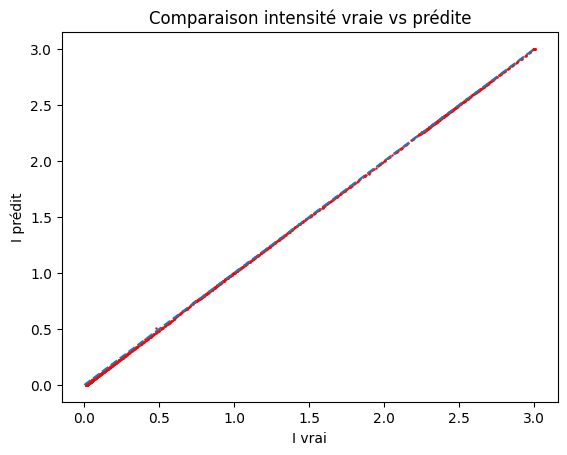

In [16]:
plt.scatter(y_test_pred[:, 2], y_true[:, 2], s=0.5, color='red')
plt.plot([0, 3], [0, 3], '--')
plt.xlabel("I vrai")
plt.ylabel("I prédit")
plt.title("Comparaison intensité vraie vs prédite")
plt.show()


In [ ]:
# plot function for a simulation
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.2)
def plot_results(results, dt):
    """
    Plots the evolution of Vb, Vs, SOC, current I, terminal voltage,
    and checks if the health constraint is violated.
    """

    # Build the time axis in minutes
    time = [k * dt / 60 for k in range(results["iterations"])]

    # Extract results
    Vb  = results["Vb"][:results["iterations"]]
    Vs  = results["Vs"][:results["iterations"]]
    SOC = results["SOC"][:results["iterations"]]
    I   = results["I"][:results["iterations"]]
    Vtr = results["Vtr"][:results["iterations"]]

    lhs = results["health"]["lhs"][:results["iterations"]]
    rhs = results["health"]["rhs"][:results["iterations"]]


    # ==========================================================
    # FIGURE 1 : Vb/Vs + SOC + Current (compact 2x2 layout)
    # ==========================================================
    plt.figure(figsize=(15, 12))

    # 1) Vb and Vs
    plt.subplot(2, 2, 1)
    plt.plot(time, Vb, label="Vb (bulk)")
    plt.plot(time, Vs, label="Vs (surface)")
    plt.xlabel("Time [min]")
    plt.ylabel("Voltages [V]")
    plt.title("Evolution of Vb and Vs")
    plt.legend()

    # 2) SOC
    plt.subplot(2, 2, 2)
    plt.plot(time, SOC, label="SOC", color="green")
    plt.axhline(0.9, linestyle="--", color="black", alpha=0.7, label="SOC target (0.9)")
    plt.xlabel("Time [min]")
    plt.ylabel("State of Charge")
    plt.ylim(0, 1)
    plt.title("SOC evolution")
    plt.legend()

    # 3) Current
    plt.subplot(2, 2, 3)
    plt.plot(time, I, label="Current I [A]", color="orange")
    plt.axhline(3, linestyle="--", color="red", alpha=0.7, label="I max = 3A")
    plt.xlabel("Time [min]")
    plt.ylabel("Current [A]")
    plt.title("Charging current")
    plt.legend()

    plt.tight_layout()
    plt.show()


    # ==========================================================
    # FIGURE : Terminal Voltage + Health Constraint (same figure)
    # ==========================================================
    plt.figure(figsize=(10, 8))

    # ----------------------------------------------------------
    # Subplot 1 : Terminal voltage
    # ----------------------------------------------------------
    plt.subplot(2, 1, 1)
    plt.plot(time, Vtr, label="Terminal voltage Vtr", color="purple")
    plt.axhline(4.2, linestyle="--", color="red", alpha=0.7, label="Vtr max = 4.2V")

    plt.xlabel("Time [min]")
    plt.ylabel("Voltage [V]")
    plt.title("Terminal Voltage Evolution")
    plt.legend()
    plt.grid(True)


    # ----------------------------------------------------------
    # Subplot 2 : Health constraint
    # ----------------------------------------------------------
    plt.subplot(2, 1, 2)
    plt.plot(time, lhs, label="Vs - Vb", color="blue")
    plt.plot(time, rhs, label="Health limit", linestyle="--", color="black")

    plt.xlabel("Time [min]")
    plt.ylabel("Constraint value")
    plt.title("Health Constraint Check")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



In [58]:
#closeLoop function
import torch
import torch.nn as nn
import numpy as np

# closeLoop adapted for your optM model
def closeLoop(model, Vs0, Vb0, N_max, SOC_final, dt,
              scaler_X=None, scaler_y=None, device=torch.device("cpu")):
    """
    Simulates the closed-loop charging process of the battery using a given controller.

    model:
        - If outputs a single current:   I_k = model([Vb, Vs])
        - If outputs 3 values (V_next, soc_next, I_k): we take I_k as the 3rd output.
        - If you trained with scaling, pass scaler_X and scaler_y.

    scaler_X, scaler_y:
        - sklearn scalers used on X_train and y_train during training (optional).
    """

    model.to(device)
    model.eval()

    # Lists to store the trajectories
    Vb = [Vb0]
    Vs = [Vs0]
    SOC = [float(soc_fn(Vb0, Vs0))]   # scalar
    I_pred = []
    Vtr = []

    health = {
        "lhs": [Vs0 - Vb0],
        "rhs": [-0.04 * SOC[0] + 0.08]
    }

    iterations = 0

    while SOC[-1] < SOC_final and iterations < N_max:
        # ---- Build current state as scalars ----
        if isinstance(Vb[-1], torch.Tensor):
            Vb_val = float(Vb[-1].item())
        else:
            Vb_val = float(Vb[-1])

        if isinstance(Vs[-1], torch.Tensor):
            Vs_val = float(Vs[-1].item())
        else:
            Vs_val = float(Vs[-1])

        # ---- Build input vector X for the model ----
        # Here I assume your model was trained on [Vb, Vs] as the first (and maybe only) features.
        x_np = np.array([[Vb_val, Vs_val]], dtype=np.float32)  # shape (1, 2)
        if scaler_X is not None:
            x_np = scaler_X.transform(x_np)

        X_input = torch.from_numpy(x_np).to(device)  # (1, 2)

        # ---- Predict current with the model ----
        with torch.no_grad():
            y_pred = model(X_input)

        # Handle different model output formats:
        #   - model returns just I
        #   - model returns (V_next, soc_next, I)
        #   - model returns y = [V_next, soc_next, I] in a single tensor
        if isinstance(y_pred, tuple):
            # Assume the last element is I_k
            I_k_tensor = y_pred[-1]
            if I_k_tensor.ndim == 1:
                I_k_tensor = I_k_tensor.view(-1, 1)   # (1, 1)
            # Assume output already unscaled if you didn't scale y
        else:
            # y_pred is a tensor, e.g. shape (1, 3): [V_next, soc_next, I_k] (possibly scaled)
            if scaler_y is not None:
                # y_pred is in scaled space → unscale it
                y_np = y_pred.cpu().numpy()
                y_unscaled = scaler_y.inverse_transform(y_np)
                I_k_scalar = float(y_unscaled[0, 2])  # 3rd column = I_k
                I_k_tensor = torch.tensor([[I_k_scalar]], dtype=torch.float32, device=device)
            else:
                # No scaling on outputs: take the 3rd component directly
                I_k_tensor = y_pred[:, 2:3]  # (1, 1)

        I_k_scalar = float(I_k_tensor.item())
        I_pred.append(I_k_scalar)

        # ---- Propagate the state with your NDC model ----
        Vb_k_tensor = torch.tensor([[Vb_val]], dtype=torch.float32, device=device)
        Vs_k_tensor = torch.tensor([[Vs_val]], dtype=torch.float32, device=device)

        Vb_k1, Vs_k1 = next_state(Vb_k_tensor, Vs_k_tensor, I_k_tensor)  # (1,1) each

        # Store them (keep tensors for now, we’ll convert to scalars at the end)
        Vb.append(Vb_k1)
        Vs.append(Vs_k1)

        # ---- Update SOC ----
        soc_k = soc_fn(Vb_k1, Vs_k1)   # tensor or scalar
        if isinstance(soc_k, torch.Tensor):
            soc_k_val = float(soc_k.item())
        else:
            soc_k_val = float(soc_k)
        SOC.append(soc_k_val)

        # ---- Compute terminal voltage ----
        ocv = u_ocp(Vs_k1)
        r0 = r0_fn(soc_k)   # accepts tensor or scalar
        Vtr_k = vtr_fn(ocv, r0, I_k_tensor)
        Vtr.append(float(Vtr_k.item()))

        # ---- Health constraint tracking ----
        health["lhs"].append(float((Vs_k1 - Vb_k1).item()))
        health["rhs"].append(float((-0.04 * soc_k_val + 0.08)))

        iterations += 1

    # Convert any remaining tensors in Vb/Vs to plain floats for plotting
    Vb_out = [float(v.item()) if isinstance(v, torch.Tensor) else float(v) for v in Vb]
    Vs_out = [float(v.item()) if isinstance(v, torch.Tensor) else float(v) for v in Vs]

    return {
        "Vb": Vb_out,
        "Vs": Vs_out,
        "SOC": SOC,
        "I": I_pred,
        "Vtr": Vtr,
        "health": health,
        "iterations": iterations
    }


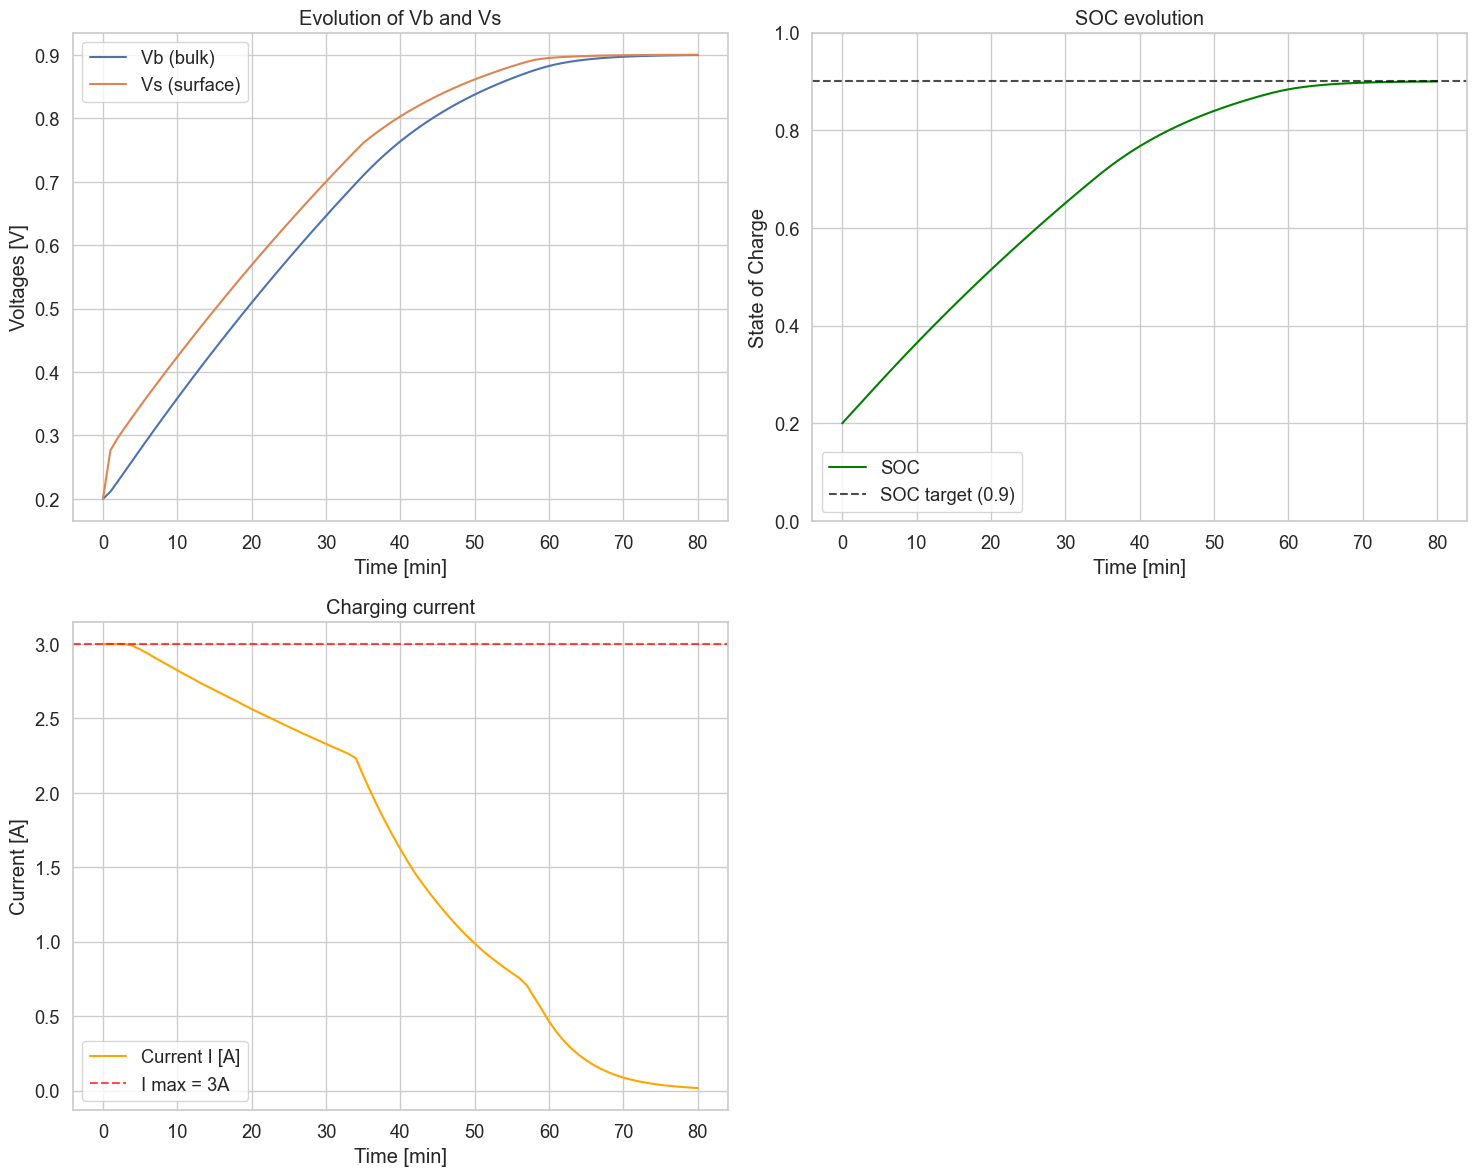

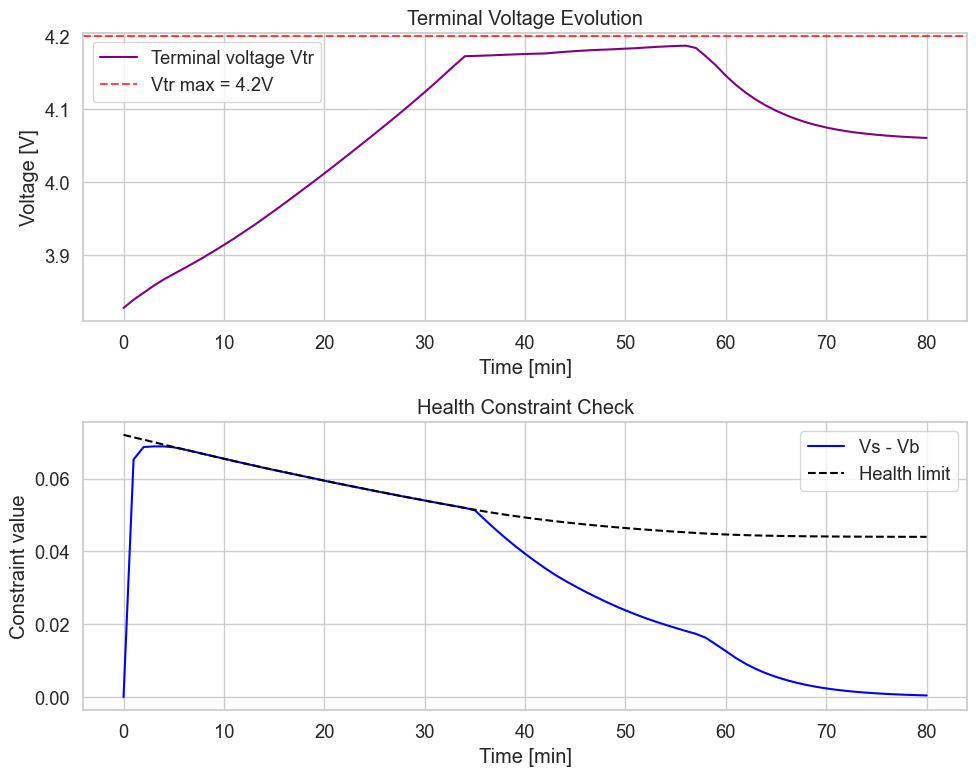

In [19]:
result = closeLoop(model,
                   Vs0=0.2,
                   Vb0=0.2,
                   N_max=100,
                   SOC_final=0.9,
                   dt=60,
                   scaler_X=scaler_X,
                   scaler_y=scaler_y,
                   device=device)

plot_results(result, dt=60)


## Recherche des violation des contraintes physiques de notre modèle

In [49]:
def sample_initial_conditions(n_samples=100):
    Vb0_list = []
    Vs0_list = []

    for _ in range(n_samples):
        SOC0 = np.random.uniform(0.05, 0.8)
        delta = np.random.uniform(-0.05, 0.05)  # Vs - Vb

        # Compute Vb and Vs from SOC equation:
        # SOC = (Cb*Vb + Cs*Vs) / (Cb+Cs)
        # With Vs = Vb + delta
        # Solve for Vb :
        Vb0 = SOC0 - (Cs/(Cb+Cs))*delta
        Vs0 = Vb0 + delta

        # Clamp to feasible region
        Vb0 = np.clip(Vb0, 0.01, 0.9)
        Vs0 = np.clip(Vs0, 0.01, 0.9)

        Vb0_list.append(Vb0)
        Vs0_list.append(Vs0)

    return np.array(Vb0_list), np.array(Vs0_list)

# Example usage
Vb0_samples, Vs0_samples = sample_initial_conditions(100)

In [ ]:
def evaluate_violations(model, Vb0_samples, Vs0_samples, N_sim, N_max, dt=60.0):
    """
    Runs N_sim closed-loop charging simulations starting from the provided
    initial conditions (Vb0_samples, Vs0_samples). Each simulation lasts N_max
    time steps. For every trajectory, the function checks:

        - current violations (I < 0 or I > 3)
        - terminal voltage violations (Vtr > 4.2)
        - health constraint violations (Vs - Vb > -0.04 * SOC + 0.08)

    It returns the mean number of violations per time step, averaged over all
    simulated points (N_sim * N_max).
    """

    # Count current violations for one simulation result
    def count_I_viol(result, I_max=3.0):
        I = result["I"]
        return sum((i < 0) or (i > I_max) for i in I)

    # Count terminal voltage violations
    def count_Vtr_viol(result):
        Vtr = result["Vtr"]
        return sum(v > 4.2 for v in Vtr)

    # Count health constraint violations
    def count_health_viol(result):
        lhs = result["health"]["lhs"]
        rhs = result["health"]["rhs"]
        return sum(l > r for l, r in zip(lhs, rhs))

    # Accumulators for violations across all simulations
    total_I_viol = 0
    total_Vtr_viol = 0
    total_health_viol = 0

    # Run each simulation
    for i in range(N_sim):
        Vb0 = Vb0_samples[i]
        Vs0 = Vs0_samples[i]

        res = closeLoop(
            model,
            Vs0=Vs0,
            Vb0=Vb0,
            N_max=N_max,
            SOC_final=0.9,
            dt=dt,
            scaler_X=scaler_X,
            scaler_y=scaler_y,
            device=device
        )

        total_I_viol      += count_I_viol(res)
        total_Vtr_viol    += count_Vtr_viol(res)
        total_health_viol += count_health_viol(res)

    # Total number of evaluated points
    total_points = N_sim * N_max

    mean_I_viol      = total_I_viol      / total_points
    mean_Vtr_viol    = total_Vtr_viol    / total_points
    mean_health_viol = total_health_viol / total_points

    return mean_I_viol, mean_Vtr_viol, mean_health_viol

In [76]:
#evaluation du nombre de violation des contraintes à partir de la fonction que nous avons definie plus haut.
Vb0_samples, Vs0_samples = sample_initial_conditions(100)

mean_I, mean_Vtr, mean_health = evaluate_violations(
    model,
    Vb0_samples,
    Vs0_samples,
    N_sim=100,
    N_max=120,
)

print("Mean I violations:", mean_I)
print("Mean Vtr violations:", mean_Vtr)
print("Mean health violations:", mean_health)

Mean I violations: 0.10416666666666667
Mean Vtr violations: 0.0
Mean health violations: 0.05875


In [77]:
#calcule le maximum d'
def evaluate_violations1(model, Vb0_samples, Vs0_samples, N_sim, N_max, dt=60.0):
    """
    Runs N_sim closed-loop charging simulations starting from the provided
    initial conditions (Vb0_samples, Vs0_samples). Each simulation lasts N_max
    time steps. For every trajectory, the function checks:

        - current violations (I < 0 or I > 3)
        - terminal voltage violations (Vtr > 4.2)
        - health constraint violations (Vs - Vb > -0.04 * SOC + 0.08)

    It returns the mean number of violations per time step, averaged over all
    simulated points (N_sim * N_max).
    """

    # Count current violations for one simulation result
    def max_I_viol(result, I_max=3.00000):
        I = result["I"]
        return max(max(i-I_max for i in I), max(-i for i in I),0)

    # Count terminal voltage violations
    def max_Vtr_viol(result):
        Vtr = result["Vtr"]
        return max(max((v- 4.2) for v in Vtr),0)

    # Count health constraint violations
    def max_health_viol(result):
        lhs = result["health"]["lhs"]
        rhs = result["health"]["rhs"]
        return max(max(l- r for l, r in zip(lhs, rhs)),0)

    # Accumulators for violations across all simulations
    total_I_viol = 0
    total_Vtr_viol = 0
    total_health_viol = 0

    # Run each simulation
    for i in range(N_sim):
        Vb0 = Vb0_samples[i]
        Vs0 = Vs0_samples[i]

        res = closeLoop(
            model,
            Vs0=Vs0,
            Vb0=Vb0,
            N_max=N_max,
            SOC_final=0.9,
            dt=dt,
            scaler_X=scaler_X,
            scaler_y=scaler_y,
            device=device
        )

        total_I_viol      += max_I_viol(res)
        total_Vtr_viol    += max_Vtr_viol(res)
        total_health_viol += max_health_viol(res)

    # Total number of evaluated points
    total_points = N_sim * N_max

    mean_I_viol      = total_I_viol      / total_points
    mean_Vtr_viol    = total_Vtr_viol    / total_points
    mean_health_viol = total_health_viol / total_points

    return mean_I_viol, mean_Vtr_viol, mean_health_viol

In [78]:
#evaluation de l'amplitude moyenne des violations des contraintes à partir de la fonction que nous avons definie plus haut.
Vb0_samples, Vs0_samples = sample_initial_conditions(100)

mean_I1, mean_Vtr1, mean_health1 = evaluate_violations1(
    model,
    Vb0_samples,
    Vs0_samples,
    N_sim=100,
    N_max=120,
)

print("Mean of Max I violations:", mean_I1)
print("Mean of Max Vtr violations:", mean_Vtr1)
print("Mean of Max health violations:", mean_health1)

Mean of Max I violations: 8.926590283711751e-07
Mean of Max Vtr violations: 0.0
Mean of Max health violations: 4.214128851890471e-07


## comparaison entre notre modèle et celui du MPC

In [23]:
#simulation of randomly chosen charges with MPC
import random
nb_simul=5
state_simulation=[]
opt_simulation=[]

simul_choice=[random.randint(1, 25) for _ in range(nb_simul)]

for i in simul_choice:
    state_simulation.append(state_test.to_numpy()[i*120-1:(i+1)*120-1])
    opt_simulation.append(opt_test.to_numpy()[i*120-1:(i+1)*120-1,:])



In [71]:
#evaluation de l'amplitude moyenne des violations des contraintes à partir de la fonction que nous avons definie plus haut.


mean_I1, mean_Vtr1, mean_health = evaluate_violations1(
    model,
    Vb0_samples=[state_simulation[0][0,1]],
    Vs0_samples=[state_simulation[0][0,0]],
    N_sim=1,
    N_max=120,
)

print("Mean I violations:", mean_I1)
print("Mean Vtr violations:", mean_Vtr1)
print("Mean health violations:", mean_health1)

Mean I violations: 0.0
Mean Vtr violations: -0.0047119990984598814
Mean health violations: 0.0024573285218536995


In [24]:
def compare_plot(results, dt,i):
    """
    Plots the evolution of Vb, Vs, SOC, current I, terminal voltage,
    and checks if the health constraint is violated.
    """

    # Build the time axis in minutes
    time = [k * dt / 60 for k in range(results["iterations"])]

    # Extract results
    Vb  = results["Vb"][:results["iterations"]]
    Vs  = results["Vs"][:results["iterations"]]
    SOC = results["SOC"][:results["iterations"]]
    I   = results["I"][:results["iterations"]]
    Vtr = results["Vtr"][:results["iterations"]]

    lhs = results["health"]["lhs"][:results["iterations"]]
    rhs = results["health"]["rhs"][:results["iterations"]]

    #MPC's informations
    Vb1=state_simulation[i][:,0]
    Vs1=state_simulation[i][:,1]
    SOC1=opt_simulation[i][:,1]
    I1=opt_simulation[i][:,2]
    Vtr1=opt_simulation[i][:,0]



    # ==========================================================
    # FIGURE 1 : Vb/Vs + SOC + Current (compact 2x2 layout)
    # ==========================================================
    plt.figure(figsize=(15, 12))

    # 1) Vb and Vs
    plt.subplot(2, 2, 1)
    plt.plot(time, Vb, label="Model Vb (bulk)")
    plt.plot(time, Vs, label="Model Vs (surface)")
    plt.plot(time, Vb1, label="MPC Vb (bulk)", marker='*')
    plt.plot(time, Vs1, label="MPC Vs (surface)", marker='*')
    plt.xlabel("Time [min]")
    plt.ylabel("Voltages [V]")
    plt.title("Evolution of Vb and Vs {}".format(i))
    plt.legend()

    # 2) SOC
    plt.subplot(2, 2, 2)
    plt.plot(time, SOC, label="Model SOC", color="green")
    plt.plot(time, SOC1, label="MPC SOC", color="blue", marker='*')
    plt.axhline(0.9, linestyle="--", color="black", alpha=0.7, label="SOC target (0.9)")
    plt.xlabel("Time [min]")
    plt.ylabel("State of Charge")
    plt.ylim(0, 1)
    plt.title("SOC evolution {}".format(i))
    plt.legend()

    # 3) Current
    plt.subplot(2, 2, 3)
    plt.plot(time, I, label="Model Current I [A]", color="orange")
    plt.plot(time, I1, label="MPC Current I [A]", color="green", marker='*')
    plt.axhline(3, linestyle="--", color="red", alpha=0.7, label="I max = 3A")
    plt.xlabel("Time [min]")
    plt.ylabel("Current [A]")
    plt.title("Charging current {}".format(i))
    plt.legend()

    plt.tight_layout()
    plt.show()


    # ==========================================================
    # FIGURE : Terminal Voltage + Health Constraint (same figure)
    # ==========================================================
    plt.figure(figsize=(10, 8))

    # ----------------------------------------------------------
    # Subplot 1 : Terminal voltage
    # ----------------------------------------------------------
    plt.subplot(2, 1, 1)
    plt.plot(time, Vtr, label="Model Terminal voltage Vtr", color="purple")
    plt.plot(time, Vtr1, label="MPC Terminal voltage Vtr", color="black", marker='*')
    plt.axhline(4.2, linestyle="--", color="red", alpha=0.7, label="Vtr max = 4.2V")

    plt.xlabel("Time [min]")
    plt.ylabel("Voltage [V]")
    plt.title("Terminal Voltage Evolution {}".format(i))
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



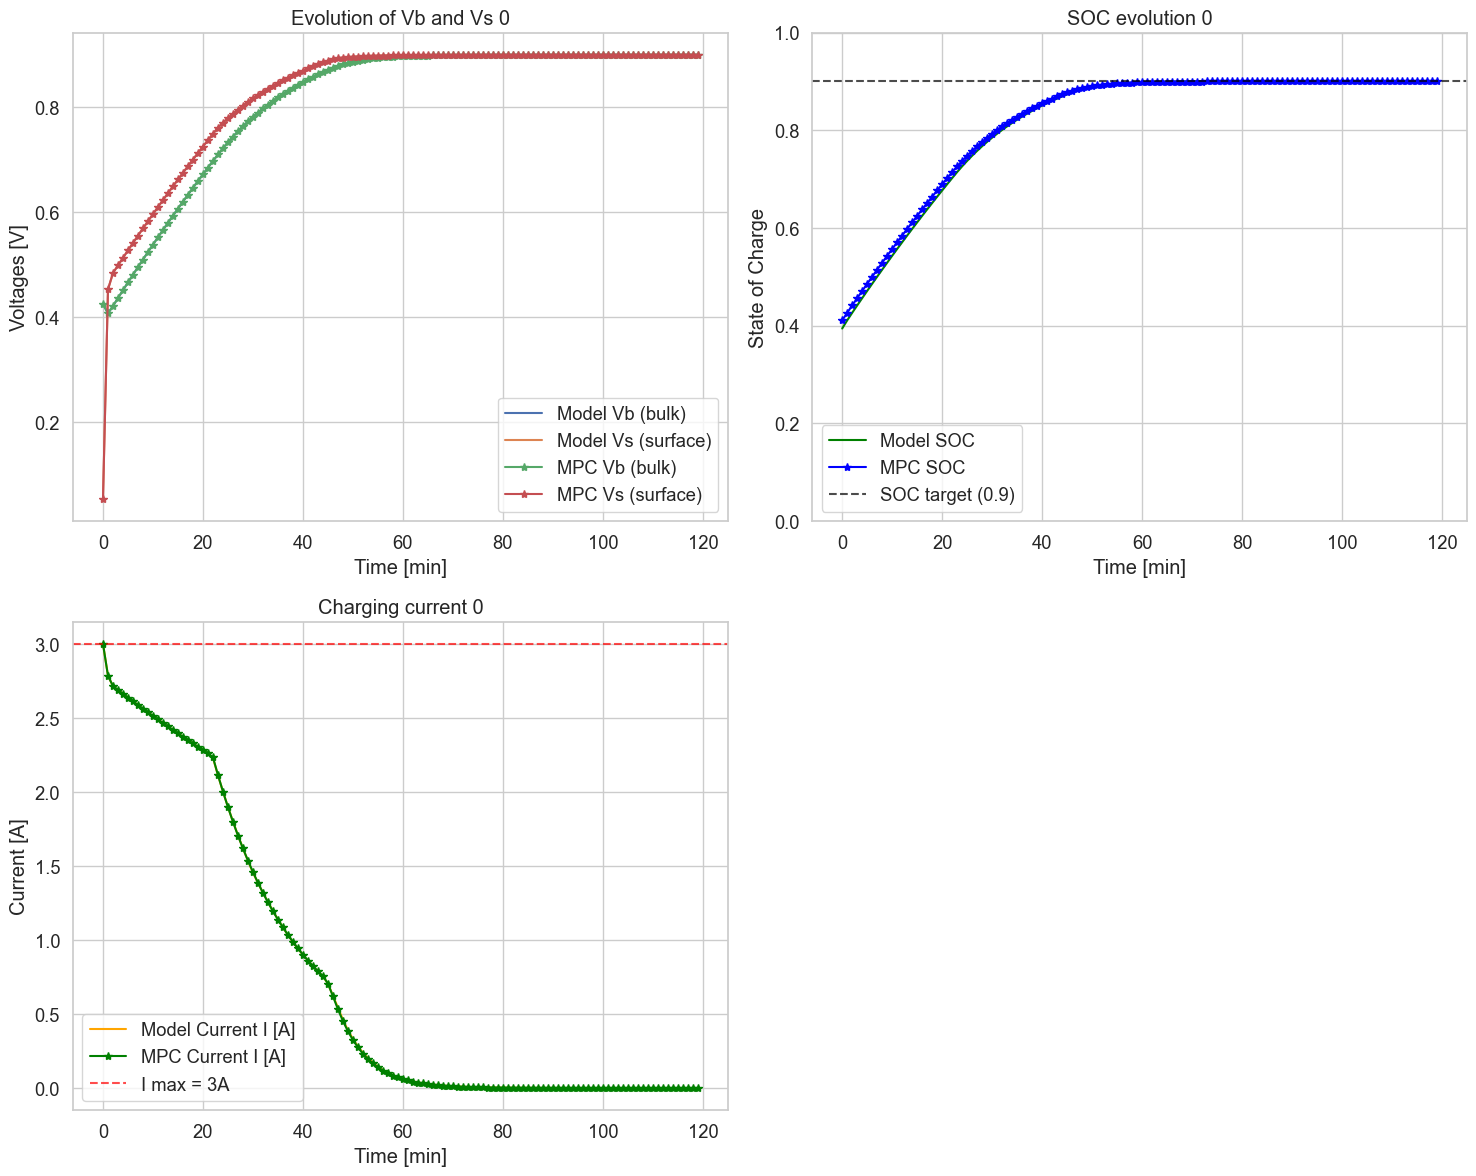

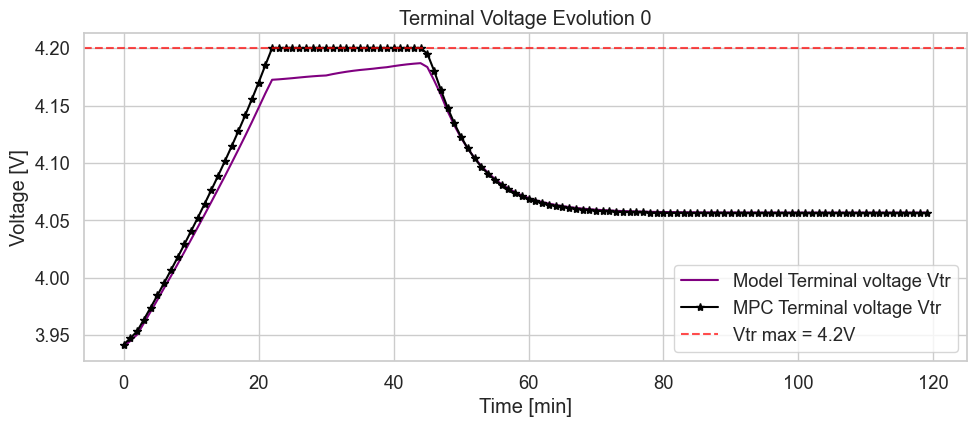

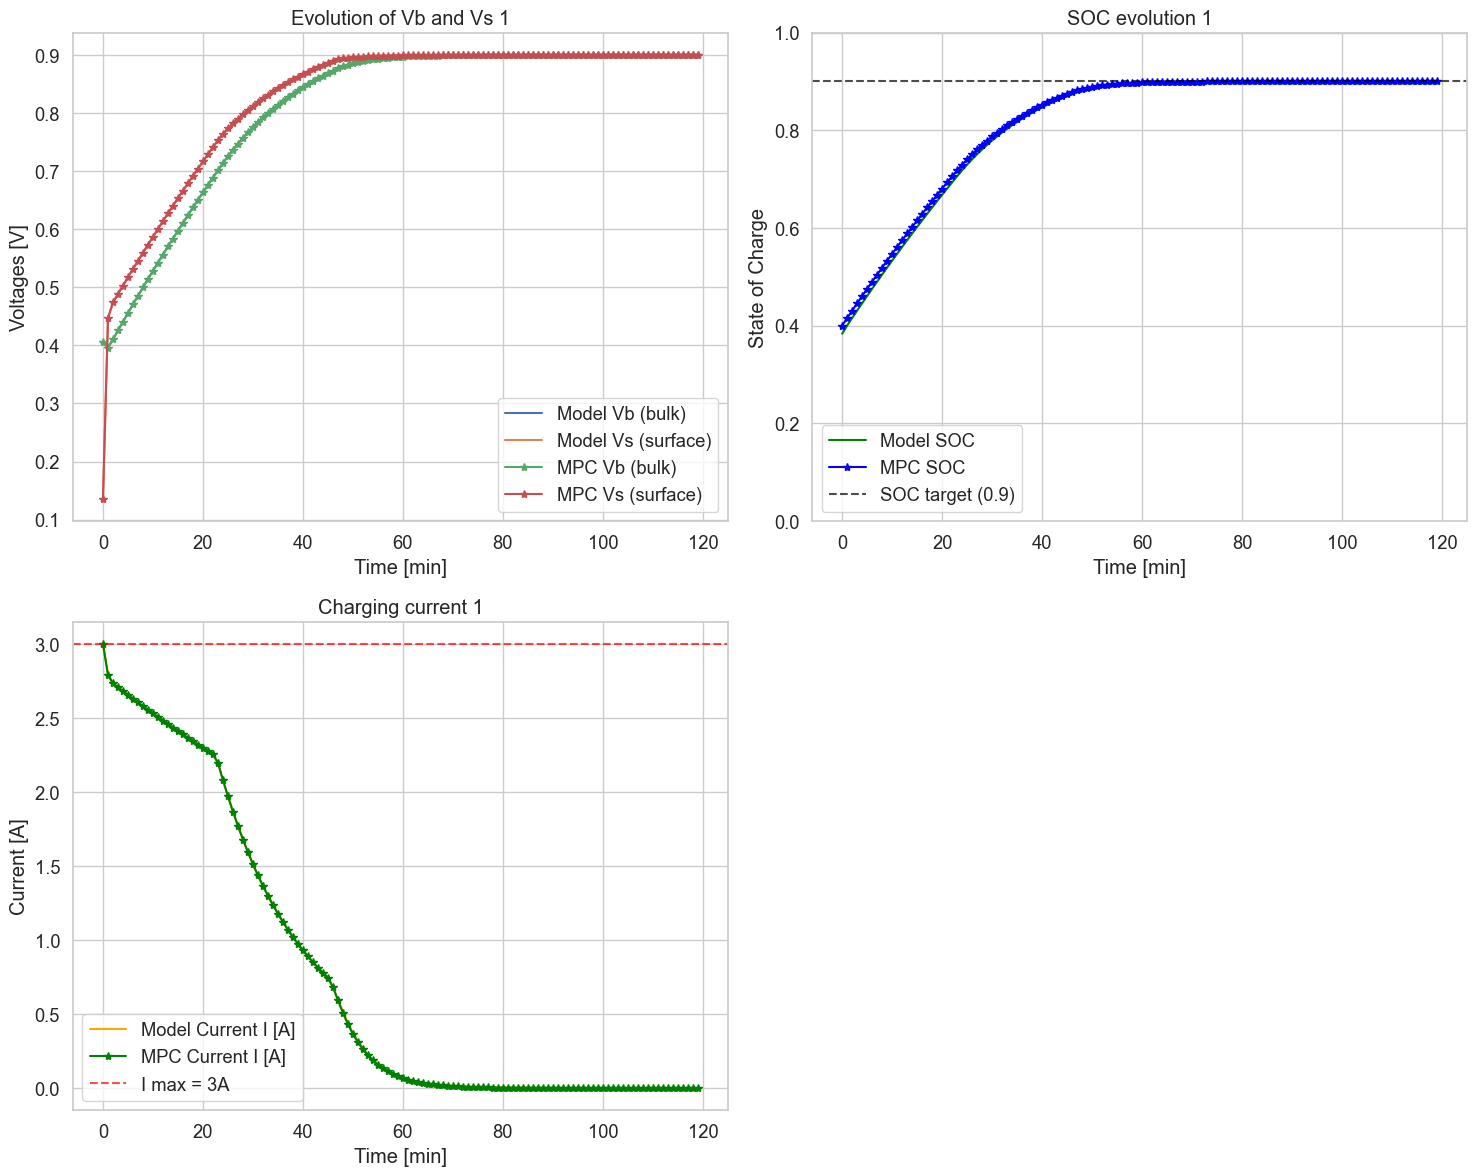

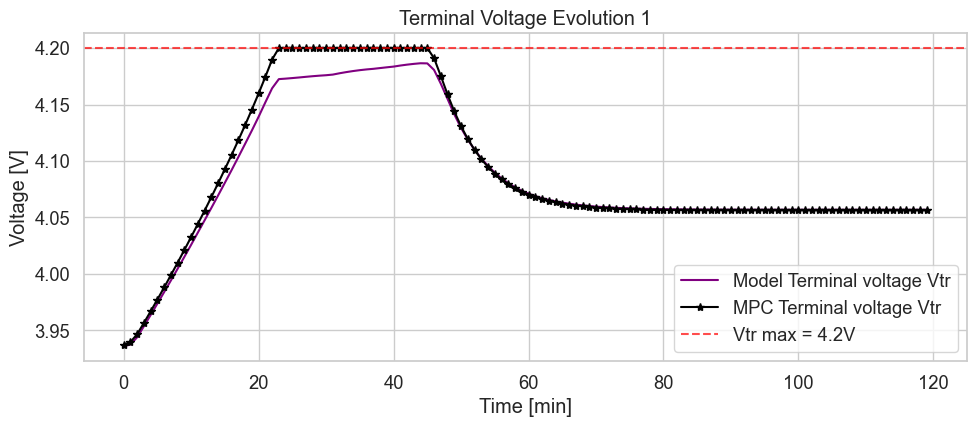

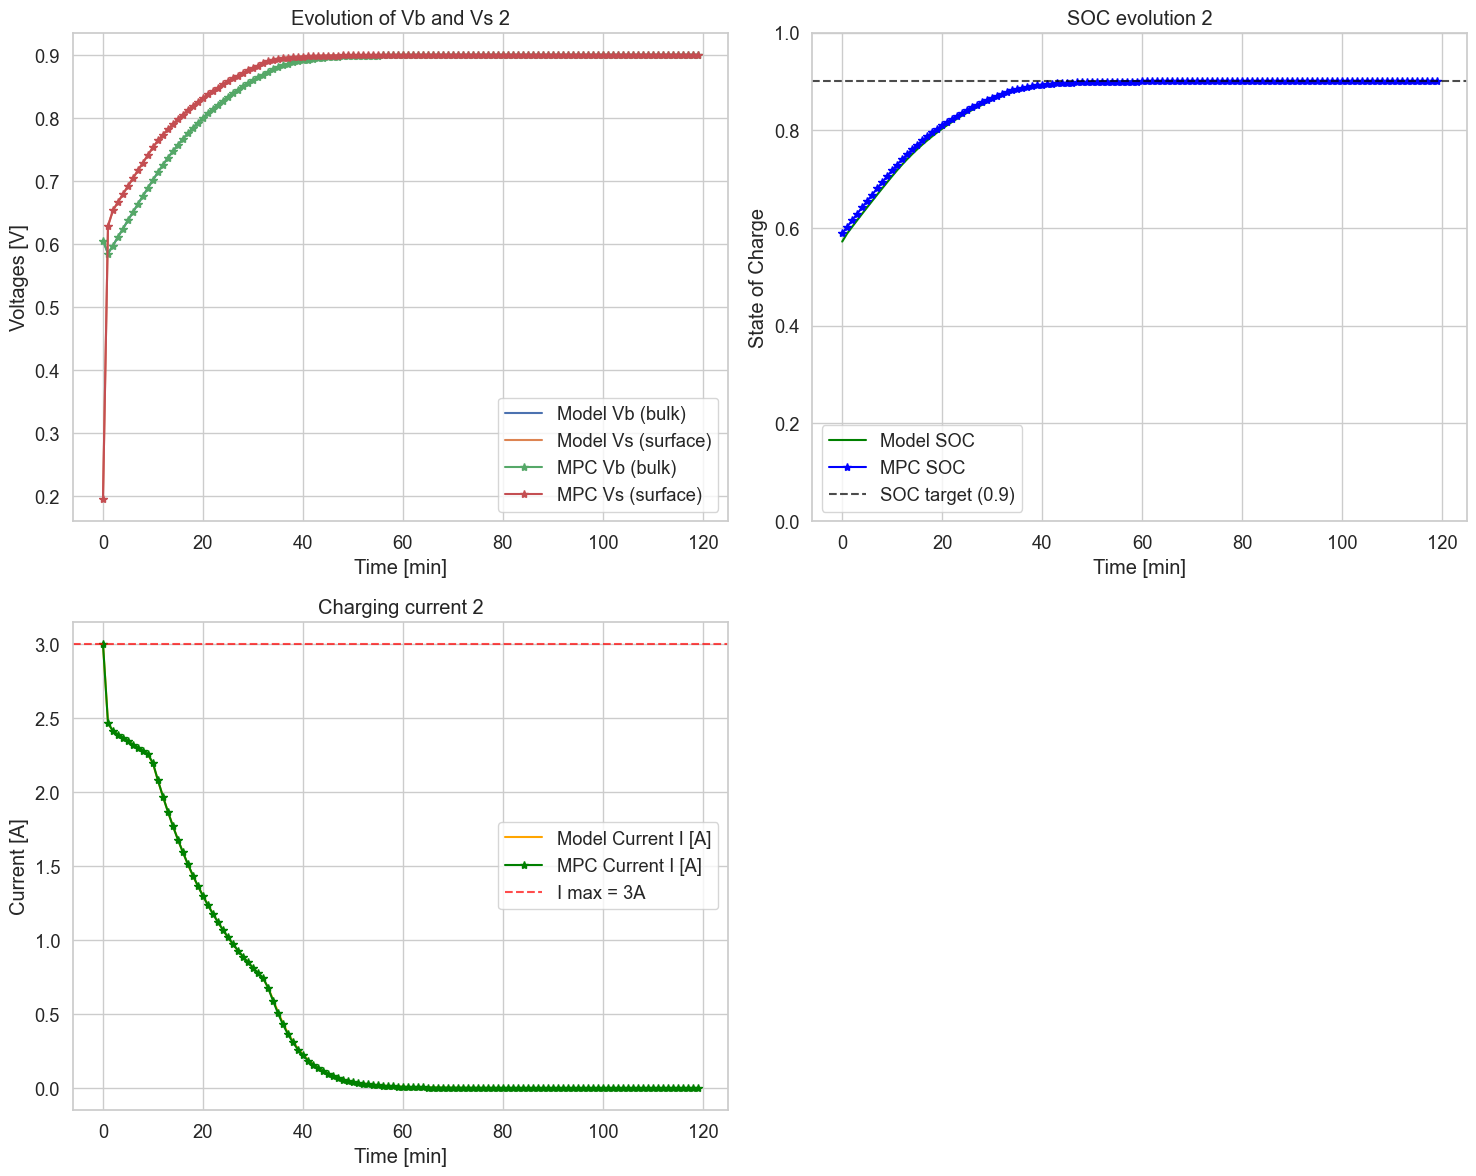

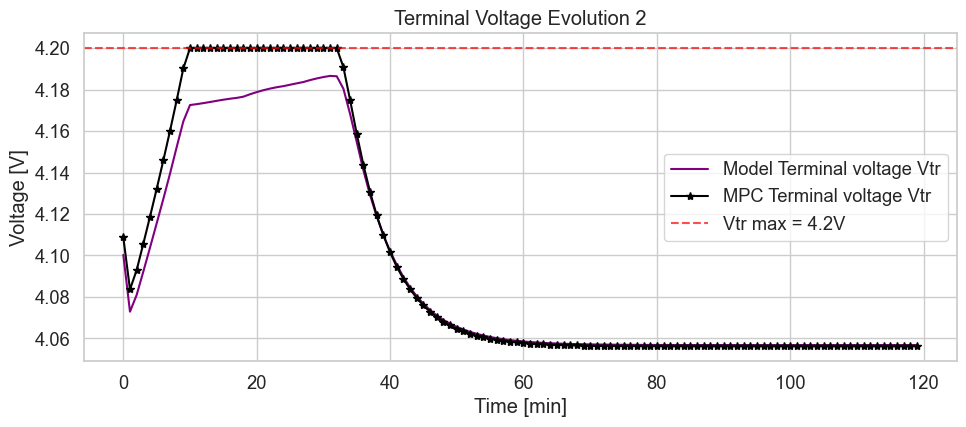

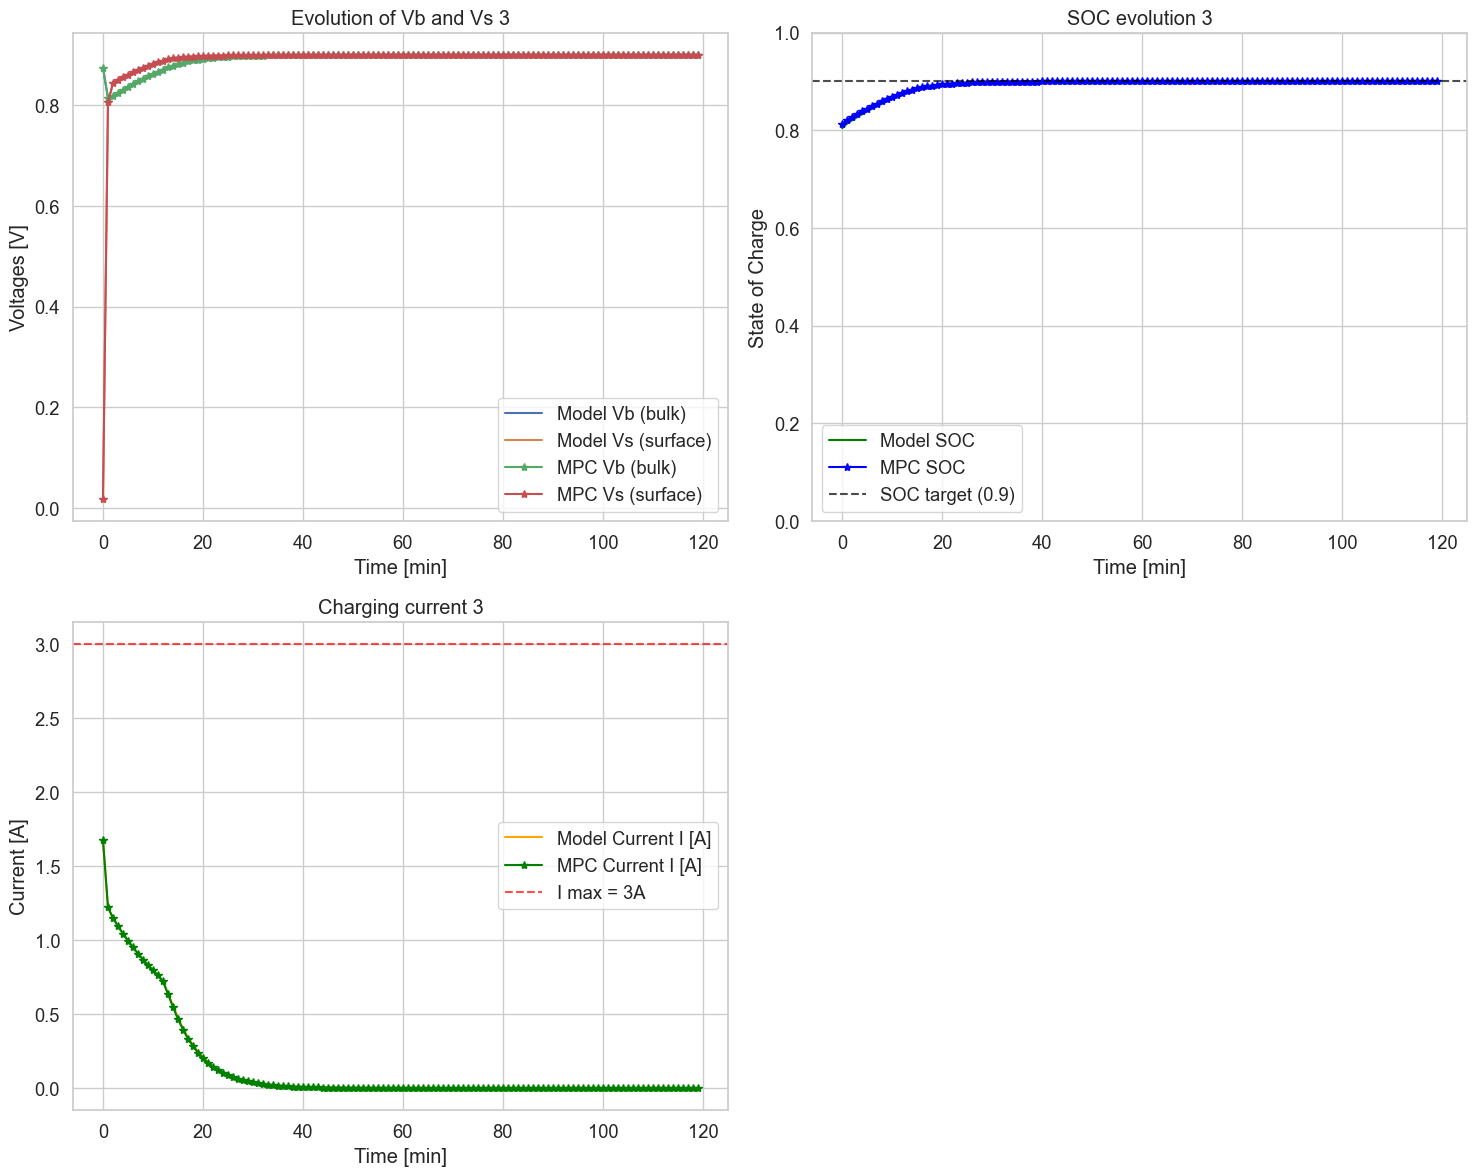

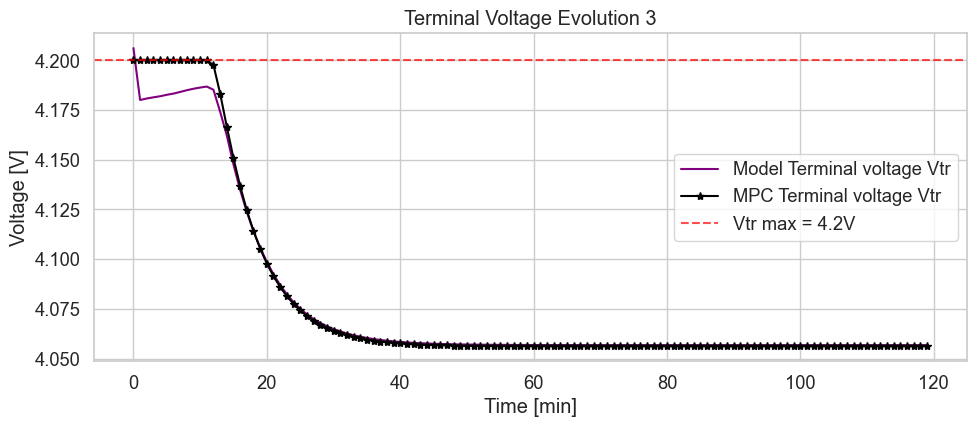

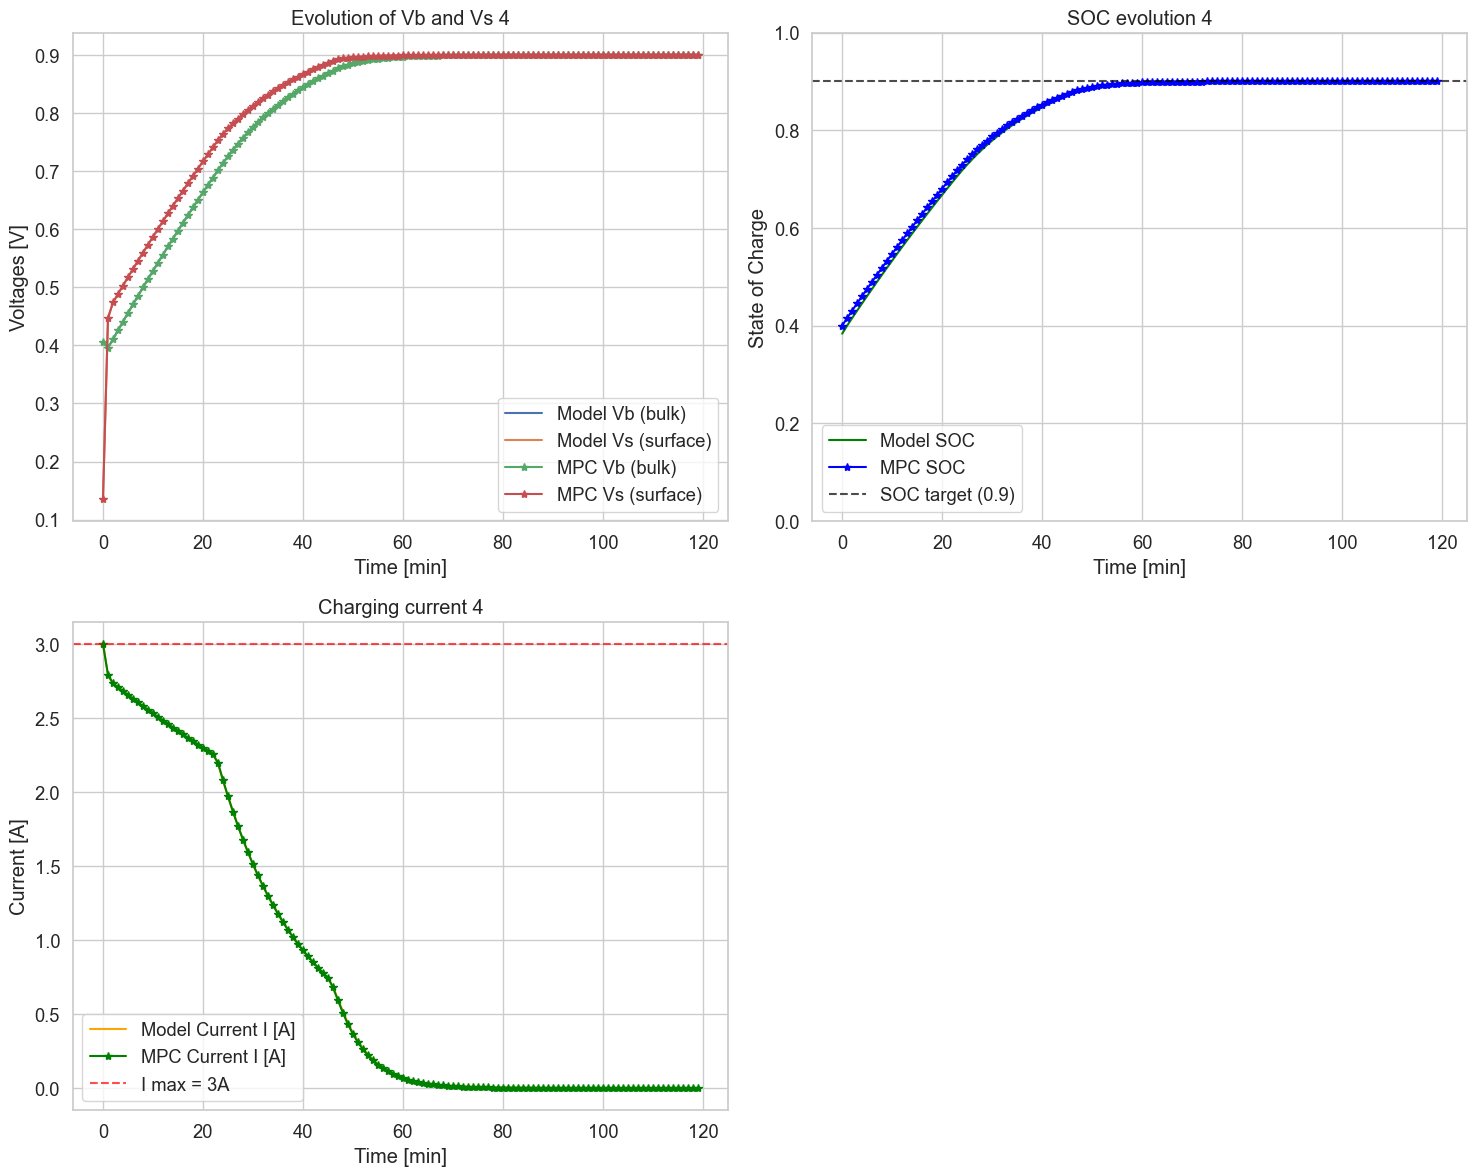

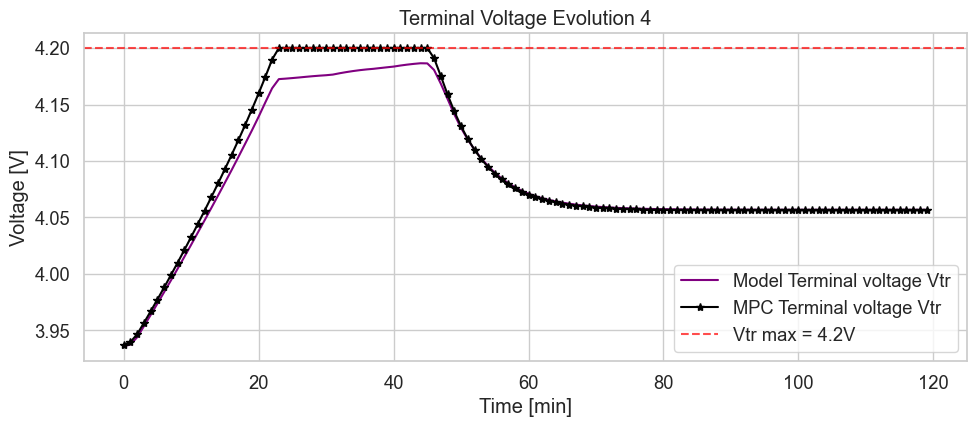

In [25]:
for i in range(len(simul_choice)):
    result=closeLoop(model,
                   Vs0=state_simulation[i][0,1],
                   Vb0=state_simulation[i][0,0],
                   N_max=120,
                   SOC_final=0.91,
                   dt=60,
                   scaler_X=scaler_X,
                   scaler_y=scaler_y,
                   device=device)

    compare_plot(result, dt=60, i=i)